### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

models_dir = 'models'

In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Splitting

In [67]:
processed_data = np.load('processed_data.npz')
X = processed_data['X']
y = processed_data['y']
labels = {0:'healthy', 1:'unhealthy'}


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed
)
# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    stratify=y_train_val,
    random_state=seed
)

# Print the shapes of the resulting datasets
print("Training_Validation Data Shape:", X_train_val.shape)
print("Training_Validation Label Shape:", y_train_val.shape)
print("Train Data Shape:", X_train.shape)
print("Train Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

In [ ]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of y_train classes:')
print(pd.DataFrame(np.argmax(y_train, axis=-1), columns=['class']).value_counts())

print('Counting occurrences of y_val classes:')
print(pd.DataFrame(np.argmax(y_val, axis=-1), columns=['class']).value_counts())

print('Counting occurrences of y_test classes:')
print(pd.DataFrame(np.argmax(y_val, axis=-1), columns=['class']).value_counts())


In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 16
epochs = 200
learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

In [ ]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
]

# Xception

## Transfer Learning

In [31]:
baseline_model = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)

In [46]:
baseline_model.trainable = False

input_layer = tfk.Input(shape=input_shape)

x = baseline_model(input_layer)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(128, activation='relu')(x)
x = tfkl.Dense(64, activation='relu')(x)
output_layer = tfkl.Dense(output_shape, activation='softmax')(x)
# Create a Model connecting input and output
tl_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='xception_tl_model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()


Model: "xception_tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 128)               262272    
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                 

In [47]:
# Train the model
tl_history = tl_model.fit(
    x = xception_preprocess_input(X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (xception_preprocess_input(X_val*255), y_val),
    callbacks = callbacks
).history

tl_model.save('models/xception_tl_model')
del tl_model


Epoch 1/200
251/251 [==============================] - 32s 125ms/step - loss: 0.5562 - accuracy: 0.7244 - val_loss: 0.5128 - val_accuracy: 0.7385
Epoch 2/200
251/251 [==============================] - 30s 120ms/step - loss: 0.4665 - accuracy: 0.7831 - val_loss: 0.5453 - val_accuracy: 0.7305
Epoch 3/200
251/251 [==============================] - 30s 120ms/step - loss: 0.4116 - accuracy: 0.8098 - val_loss: 0.4924 - val_accuracy: 0.7665
Epoch 4/200
251/251 [==============================] - 30s 119ms/step - loss: 0.3774 - accuracy: 0.8328 - val_loss: 0.4901 - val_accuracy: 0.7625
Epoch 5/200
251/251 [==============================] - 31s 125ms/step - loss: 0.3442 - accuracy: 0.8511 - val_loss: 0.5109 - val_accuracy: 0.7705
Epoch 6/200
251/251 [==============================] - 32s 126ms/step - loss: 0.2888 - accuracy: 0.8741 - val_loss: 0.5359 - val_accuracy: 0.7904
Epoch 7/200
251/251 [==============================] - 30s 120ms/step - loss: 0.2591 - accuracy: 0.8891 - val_loss: 0.5851 -

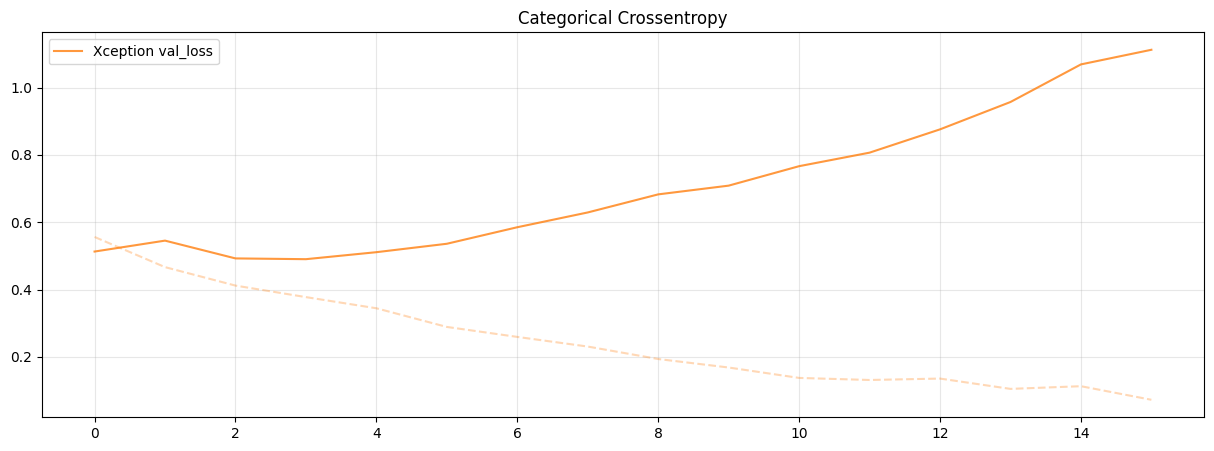

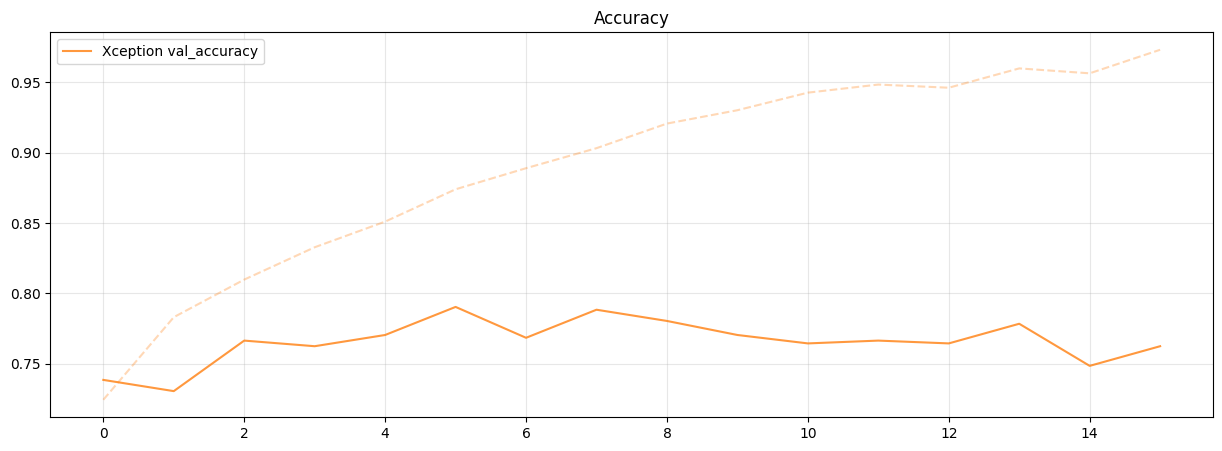

In [50]:
# Plot the transfer learning xception training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_loss'], label='Xception val_loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Xception val_accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Fine Tuning

In [56]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('models/xception_tl_model')
ft_model.summary()

Model: "xception_tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 128)               262272    
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                 

In [57]:
# Set all xception layers as trainable
ft_model.get_layer('xception').trainable = True
layers = ft_model.get_layer('xception').layers
for i, layer in enumerate(layers):
   print(i, layer.name, layer.trainable)

0 input_5 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_8 True
13 block2_pool True
14 batch_normalization_8 True
15 add_24 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_9 True
23 block3_pool True
24 batch_normalization_9 True
25 add_25 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_10 True
33 block4_pool True
34 batch_normalization_10 True
35 add_26 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42

In [58]:
# Freeze first N layers, e.g., until the 133rd one
N = 100
for i, layer in enumerate(layers[:N]):
  layer.trainable=False
for i, layer in enumerate(layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_5 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_8 False
13 block2_pool False
14 batch_normalization_8 False
15 add_24 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_9 False
23 block3_pool False
24 batch_normalization_9 False
25 add_25 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_10 False
33 block4_pool False
34 batch_normalization_10 False
35 add_26 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sep

In [59]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [61]:
# Train the model
ft_history = ft_model.fit(
    x = xception_preprocess_input(X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (xception_preprocess_input(X_val*255), y_val),
    callbacks = callbacks
).history

Epoch 1/200
251/251 [==============================] - 64s 255ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.7190 - val_accuracy: 0.8044
Epoch 2/200
251/251 [==============================] - 62s 246ms/step - loss: 0.1146 - accuracy: 0.9600 - val_loss: 1.0708 - val_accuracy: 0.7884
Epoch 3/200
251/251 [==============================] - 58s 231ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.7466 - val_accuracy: 0.8104
Epoch 4/200
251/251 [==============================] - 56s 223ms/step - loss: 0.0536 - accuracy: 0.9835 - val_loss: 0.9111 - val_accuracy: 0.8144
Epoch 5/200
251/251 [==============================] - 60s 240ms/step - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.8590 - val_accuracy: 0.8144
Epoch 6/200
251/251 [==============================] - 60s 239ms/step - loss: 0.0198 - accuracy: 0.9925 - val_loss: 0.9663 - val_accuracy: 0.8084
Epoch 7/200
251/251 [==============================] - 59s 237ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 1.0934 -

In [62]:
ft_model.save('models/xception_ft_model')
del ft_model

## Make Inference

In [63]:
model_name = 'xception_ft_model'
model = tfk.models.load_model(f'{models_dir}/{model_name}')
model.summary()

Model: "xception_tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 128)               262272    
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                 

In [64]:
# Predict labels for the entire test set
predictions = model.predict(xception_preprocess_input(X_test * 255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 2)


Accuracy: 0.8144
Precision: 0.8087
Recall: 0.7917
F1: 0.7982


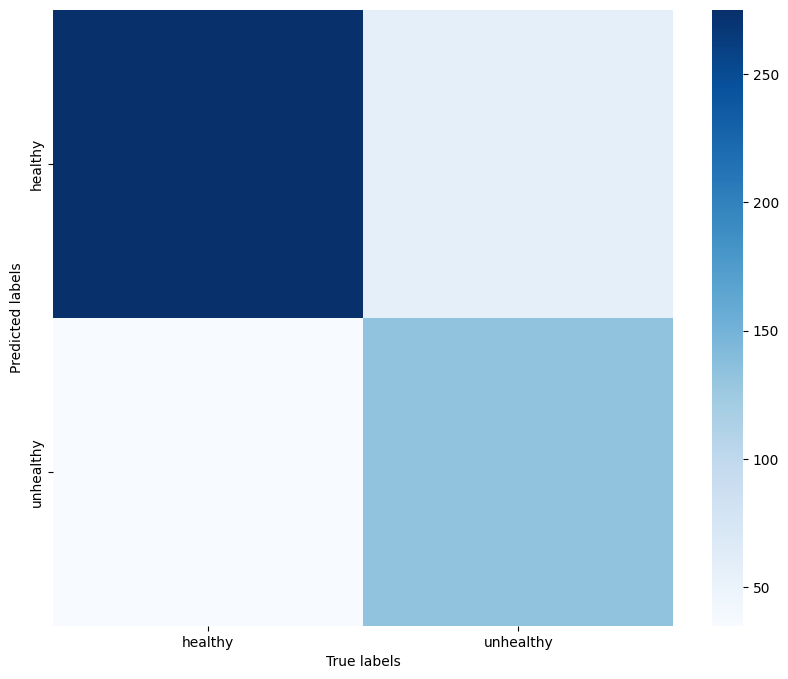

In [68]:

# Compute the confusion matrix
rounded_predictions = np.argmax(predictions, axis=-1)
cm = confusion_matrix(np.argmax(y_test, axis=-1), rounded_predictions)

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), rounded_predictions)
precision = precision_score(np.argmax(y_test, axis=-1), rounded_predictions, average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), rounded_predictions, average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), rounded_predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()